In [1]:
import scipy
import scipy.fftpack
import scipy.special
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import time
from numpy.fft import rfft, irfft, fft, ifft
from filamentsim import *
from pathlib import Path

import sympy
import math

In [2]:
L0 = 1
dim = 3

Nm = 500
Mm = Nm

Mm_render = Mm

N_circle = 100
N_fibres = 5
tube_radius = 0.1

In [3]:
path_handler = filamentsim.cheb.ChebHandler(dim, Nm, Mm, L0, mpmath_dps=-1)
us = path_handler.grid

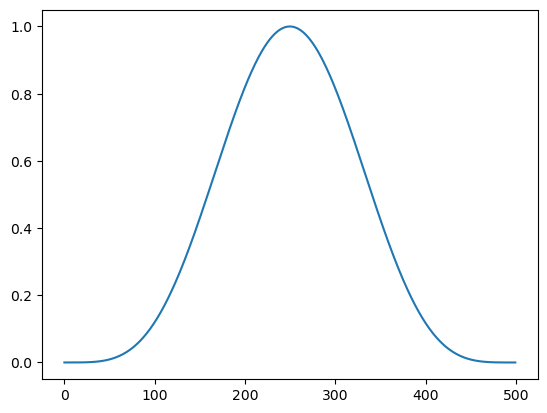

In [4]:
env = -us*(us-L0)
env = env**2
env /= np.max(env)
plt.plot(env)

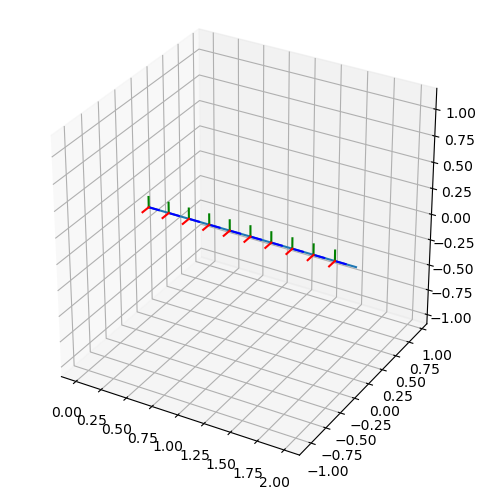

In [5]:
th = np.zeros((3, Mm))
th[0] = 2
th[1] = 0

pi = np.zeros((3, Mm))

pi[0] = 0
pi[1] = 0

###

frame_rot_ampl = 0

frame_rot_th = 0* env * np.sin(np.pi*path_handler.grid/L0) * frame_rot_ampl
frame_rot_phi =  env * np.sin(np.pi*path_handler.grid/L0) * frame_rot_ampl
frame_rot_psi =  0* env * np.sin(np.pi*path_handler.grid/L0) * frame_rot_ampl

E_u0 = np.array([
    [1,0,0],
    [0,0,-1],
    [0,1,0]
])

# Rotate the frame

frame_rotation = eul2rot([frame_rot_th, frame_rot_phi, frame_rot_psi])

du_frame_rotation = np.zeros(frame_rotation.shape)
for i in range(3):
    du_frame_rotation[i,:] = path_handler.diff_f( frame_rotation[i,:] )
    
pi_hat = hat_vec_to_mat(pi)

transformed_pi_hat = np.einsum('iju,kju->iku', du_frame_rotation, frame_rotation)
transformed_pi_hat += np.einsum('iju,jku,lku->ilu', frame_rotation, pi_hat, frame_rotation)
transformed_pi = hat_mat_to_vec(transformed_pi_hat)

transformed_th = np.einsum('iju,ju->iu', frame_rotation, th)

E_u0 = E_u0.dot(frame_rotation[...,0].T)

th = transformed_th
pi = transformed_pi

th_render = path_handler.cheb_to_unif(th, Mm_unif=Mm_render)
pi_render = path_handler.cheb_to_unif(pi, Mm_unif=Mm_render)
Fr, R, E = reconstruct_frame(th_render, hat_vec_to_mat(pi_render), L0, E_u0=E_u0)

fig = plt.figure(figsize=(6,6))
plot_centerline_and_frame(R, E, fig=fig, N_frame=10, frame_scale=0.05)
plt.show()

(<Figure size 600x600 with 1 Axes>, <AxesSubplot:>)

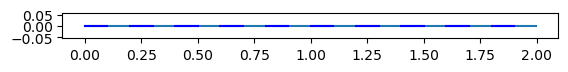

In [6]:
plot_centerline_and_frame_2D(R, E, fig=fig, N_frame=10, frame_scale=0.05)

In [7]:
def get_tube(N_circle, radius):
    xs_circle = np.linspace(0, 2*np.pi, N_circle+1)[:-1]

    tube = np.zeros((N_circle, 3, Mm))
    e1, e2, e3 = E[:,0], E[:,1], E[:,2]

    for i in range(N_circle):
        x = xs_circle[i]
        tube[i] = R + (e2*np.cos(x) + e3*np.sin(x))*radius
        
    return tube

def save_tube(tube, fn):
    tube_points = np.concatenate([ t.T for t in tube ])
    tube_points.astype('float32').tofile('%s.dat'% fn)

In [8]:
_E = E*tube_radius
e1, e2, e3 = _E[:,0], _E[:,1], _E[:,2]

In [9]:
tube = get_tube(N_circle, tube_radius)
fibres = get_tube(N_fibres, tube_radius)

save_tube(tube, 'tube')
np.swapaxes(fibres, 1, 2).astype('float32').tofile('fibres.dat')

R.T.astype('float32').tofile('R.dat')
e1.T.astype('float32').tofile('e1.dat')
e2.T.astype('float32').tofile('e2.dat')
e3.T.astype('float32').tofile('e3.dat')

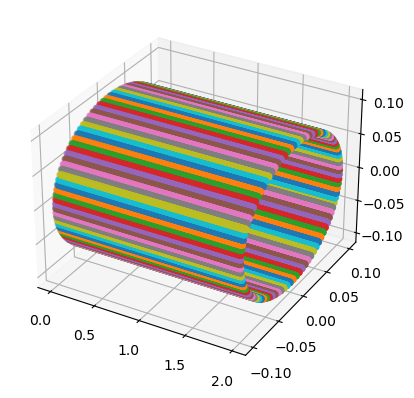

In [10]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(N_circle):
    xs,ys,zs = tube[i]
    ax.scatter(xs,ys,zs)
    
plt.show()

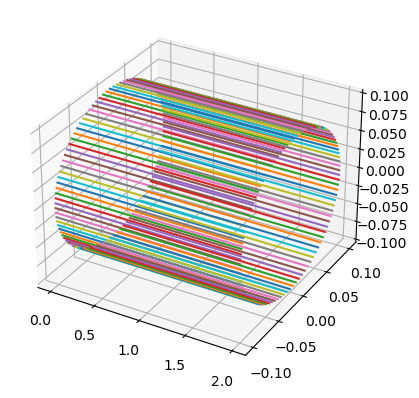

In [11]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(N_circle):
    xs,ys,zs = tube[i]
    ax.plot(xs,ys,zs)
    
plt.show()